Some initial comments: Even as an EDA assignment, this is a work in progress. I've played around quite a bit with the data, and I think some of that is a reflection of my level of comfort (or lack thereof) with some modeling processes. Still, I hope this constitutes a reasonable beginning. 

In [1]:
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import os

os.chdir('C:\Users\jhoukal\Desktop\New folder')

files = [f for f in os.listdir(os.getcwd()) if f.endswith('csv')]
files #I'd like to make this part dynamic, but for the meantime I at least get a quick list of the files I want to upload

Login = pd.read_csv('LoginData.csv')
Login.rename(columns={ Login.columns[0]: "ENTITY"}, inplace=True)

Partner = pd.read_csv('PartnerData.csv')
Partner.rename(columns={ Partner.columns[0]: "ENTITY"}, inplace=True)

Events = pd.read_csv('EventData.csv')
Events.rename(columns={ Events.columns[0]: "ENTITY"}, inplace=True)

SF = pd.read_csv('Salesforce.csv')
SF.rename(columns={ SF.columns[0]: "ENTITY"}, inplace=True)
SF.drop_duplicates(['ENTITY'], inplace=True) #because multiple case records are logged for each user, thereby duplicating users

In [3]:
df = pd.merge(Login, 
              pd.merge(Events, 
                       Partner, 
                       on='ENTITY', how='outer'),
                  on='ENTITY', how='outer')

df.drop_duplicates(['ENTITY'], inplace=True) #occasional duplicate users here, too. I don't need them. 

df['CONTACT'] = np.where(df['ENTITY'].isin(SF['ENTITY']), True,np.nan) #true/false if member actually contacted. 

In [4]:
df.head()
df.set_index('ENTITY', inplace=True) #let's set our index, too:

In [5]:
print(df.isnull().sum()) #checking range of missing values.

FIRST_APP_LOGIN_DATE    273916
FIRST_WEB_LOGIN_DATE     18400
earned_status_adj        18449
hra_completion_date     232976
vc_completion_date      383453
COVERAGE_EFF_DATE        18331
eventdesc               493768
partner_name            283250
CONTACT                 453014
dtype: int64


We must interpret missing values before we can address them. A missing value in the login columns isn't missing data per se; rather, it (normally) indicates that the user hasn't used the specified platform. In my experience, it is safer to treat these as FALSEs or NULLs rather than missing values. As such, I will convert these sorts of columns into booleans.   

In [6]:
#so, let's convert them to ones and zeros. 
mydata = df.notnull().astype('int')

In [7]:
#I also want to get a sort of "waterfall" count...
#Basically, this is the count of conversions for each feature

(mydata == 1).sum(axis=1)#sum of conversions by row (member)
(mydata == 1).sum(axis=0)#sum of conversions by column (feature)
 

FIRST_APP_LOGIN_DATE    257255
FIRST_WEB_LOGIN_DATE    512771
earned_status_adj       512722
hra_completion_date     298195
vc_completion_date      147718
COVERAGE_EFF_DATE       512840
eventdesc                37403
partner_name            247921
CONTACT                  78157
dtype: int64

In [8]:
#let's then order our columns appropriately
mydata = mydata[mydata.sum().sort_values(ascending = False).index]
mydata.head()

,COVERAGE_EFF_DATE,FIRST_WEB_LOGIN_DATE,earned_status_adj,hra_completion_date,FIRST_APP_LOGIN_DATE,partner_name,vc_completion_date,CONTACT,eventdesc
ENTITY,,,,,,,,,
1400066864,1,1,1,0,0,0,0,0,0
1400078091,1,1,1,0,0,0,0,1,0
1400080725,1,1,1,1,1,1,1,0,0
1400099642,1,1,1,1,0,0,1,1,0
1400104459,1,1,1,1,1,1,0,1,0


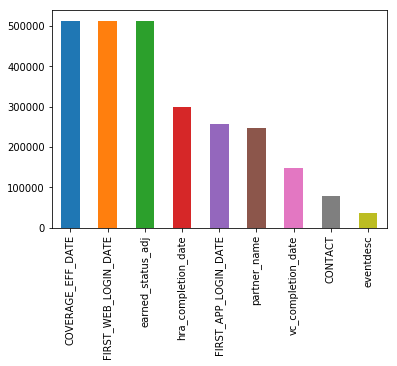

In [9]:
#finally, our waterfall
ax = (mydata == 1).sum(axis=0).plot.bar() 

We see roughly equivalent eff dates, login dates, and earned statuses, which is not surprising because these are almost defaults. Web login requires some member action, but it's not until we see HRA through eventdesc that we have some feature columns requiring user agency. I therefore think it makes sense to drop coverage eff date and earned status. 

In [10]:
mydata.drop(['COVERAGE_EFF_DATE', 'earned_status_adj'], axis=1, inplace=True)

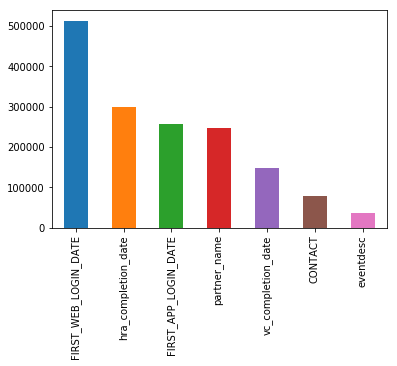

In [11]:
ax = (mydata == 1).sum(axis=0).plot.bar() #much better!

In [12]:
print(mydata.mean(axis=0))

FIRST_WEB_LOGIN_DATE    0.965360
hra_completion_date     0.561392
FIRST_APP_LOGIN_DATE    0.484317
partner_name            0.466744
vc_completion_date      0.278099
CONTACT                 0.147141
eventdesc               0.070416
dtype: float64


In [13]:
mydata.groupby(mydata.sum(axis=1)).agg(sum) #users grouped by count of feature conversions, up to 7 (and apparently not less than 1)

,FIRST_WEB_LOGIN_DATE,hra_completion_date,FIRST_APP_LOGIN_DATE,partner_name,vc_completion_date,CONTACT,eventdesc
1,135374,0,61,14169,0,0,616
2,87558,39639,28243,12145,7037,6920,558
3,78373,53750,38802,31703,25393,6061,1223
4,92298,86476,75193,74267,26253,11556,3149
5,78979,78181,75051,75631,54124,21555,11374
6,33615,33575,33331,33432,28337,25491,13909
7,6574,6574,6574,6574,6574,6574,6574


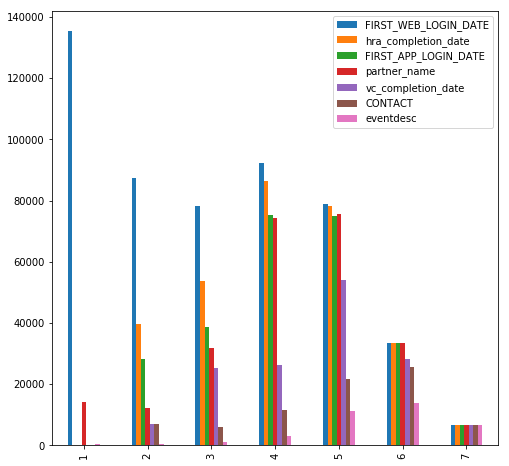

In [14]:
ax = mydata.groupby(mydata.sum(axis=1)).agg(sum).plot.bar(figsize=(8,8))

It certainly makes sense for the clustered bars to flatten as we move from left to right. It's interesting that four variables applies to more users than two or three variables, but it makes sense for those easy behaviors to be correlated (whereas vc_completion is harder to achieve). The cohort of users who've contacted us seems quite small, but it's important to note that I am using a pretty small set of data for this initial EDA. 

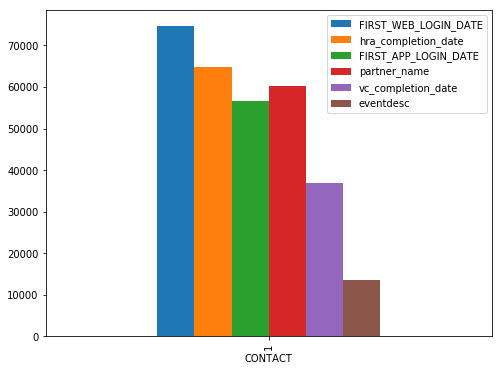

In [15]:
#Let's see some color!
#number of contact conversions for each grouping
ax=mydata[mydata.loc[:, 'CONTACT']==1].groupby('CONTACT').agg(sum).plot.bar(figsize=(8,6))

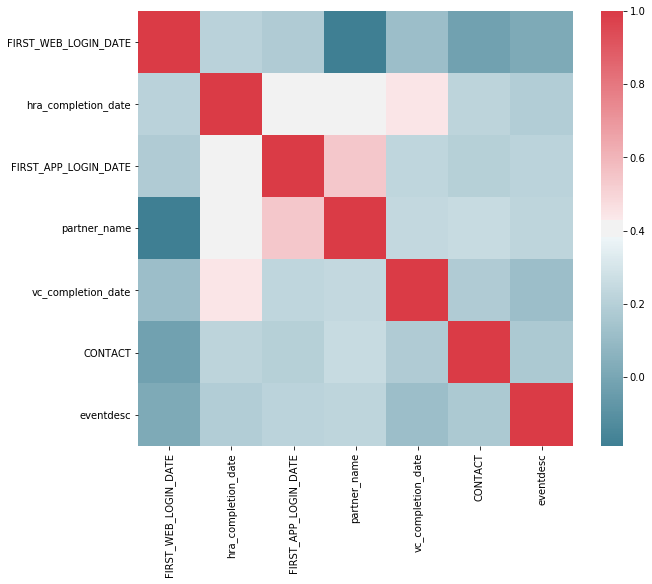

In [16]:
corr = mydata.corr()
f, ax = plt.subplots(figsize=(10, 8))
g = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#no single variable seems to correlate too strongly to a contact, but partnername is a promising lead

In [17]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

feature_cols = ['partner_name']
X = mydata.loc[:, feature_cols]
y = mydata.loc[:, 'CONTACT']

linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
y_pred = linreg.predict(X)
mydata.loc[:, 'y_pred'] = y_pred

In [19]:
print(linreg.intercept_)
print(linreg.coef_)

0.06320564872020357
[0.17983145]


In [20]:
#linreg isn't too helpful. Let's try logit. 

mydata.drop(['y_pred'], axis=1, inplace=True)
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()


feature_cols = [i for i in mydata if ('CONTACT' not in i and 'pred' not in i)]
X = mydata.loc[:, feature_cols]
y = mydata.loc[:, 'CONTACT']

logreg.fit(X,y)
pred = logreg.predict(X)

In [21]:
feature_cols

['FIRST_WEB_LOGIN_DATE',
 'hra_completion_date',
 'FIRST_APP_LOGIN_DATE',
 'partner_name',
 'vc_completion_date',
 'eventdesc']

In [22]:
logreg.predict_proba(X)[0:10]

array([[0.96764243, 0.03235757],
       [0.96764243, 0.03235757],
       [0.694829  , 0.305171  ],
       [0.88157077, 0.11842923],
       [0.78011857, 0.21988143],
       [0.78011857, 0.21988143],
       [0.79332193, 0.20667807],
       [0.96764243, 0.03235757],
       [0.96764243, 0.03235757],
       [0.90144802, 0.09855198]])

In [23]:
mydata.loc[:, 'CONTACT_PROB'] = logreg.predict_proba(X)[:, 1]

In [24]:
mydata.loc[:, 'CONTACT_PROB'].value_counts().sort_values(ascending=False)

0.032358    138909
0.219881     70868
0.305171     66707
0.079369     42980
0.046619     29653
0.118429     26129
0.098552     21833
0.111954     18468
0.187150     17545
0.459968     14698
0.353421     14410
0.161599     13566
0.164191     13101
0.230975     12648
0.069562      9479
0.049527      7438
0.070802      1987
0.145560      1745
0.174928      1676
0.368074       900
0.196453       779
0.143241       775
0.275869       740
0.272088       717
0.206678       708
0.104343       643
0.166465       624
0.060900       473
0.086616       328
0.308676       162
0.248331       158
0.126627       142
0.130880        62
0.091777        58
0.128744        35
0.184290        20
0.190058         3
0.251878         3
0.464669         1
Name: CONTACT_PROB, dtype: int64

In [29]:
print(len(mydata[mydata.loc[:, 'CONTACT_PROB'] > 0.4]))
mydata[mydata.loc[:, 'CONTACT_PROB'] > 0.4].head()
#presumably the likeliest contacts. 
#In other words, people for whom all conversions are true have a slightly higher chance of contacting us than 
#people for whom any other sets of conversions are true. That makes sense--but is it helpful?


14699


,FIRST_WEB_LOGIN_DATE,hra_completion_date,FIRST_APP_LOGIN_DATE,partner_name,vc_completion_date,CONTACT,eventdesc,CONTACT_PROB
ENTITY,,,,,,,,
1400249080,1,1,1,1,1,0,1,0.459968
1400598064,1,1,1,1,1,1,1,0.459968
1403289042,1,1,1,1,1,0,1,0.459968
1403289067,1,1,1,1,1,0,1,0.459968
1403290487,1,1,1,1,1,0,1,0.459968


This, clearly, still is not very helpful. Let's try a non-parametric approach.

In [30]:
from sklearn.tree import DecisionTreeClassifier

X = mydata.loc[:, feature_cols]
y = mydata.loc[:, 'CONTACT']

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [44]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,FIRST_WEB_LOGIN_DATE,0.000000
1,hra_completion_date,0.080374
2,FIRST_APP_LOGIN_DATE,0.002230
3,partner_name,0.678932
4,vc_completion_date,0.103570
5,eventdesc,0.134894


Some comments for next time: 
I wonder if engagement factors will suffice. I am having some difficulty gathering full demographic date (age, gender, etc.), but will try to blend those factors into the final product. 
I also have not fully reckoned with a really severe limitation to this data: we don't know whether these engagement factors were true before the user actually contacted us. It could be that they are more engaged post-conversion. One might with some justice assume that this cohort was more inclined to engage anyway, but that's still an unchastened assumption. 
Finally, 46% contact probability with logistic regression is still less than my goal of >50%. 